# **Imports**

In [1]:
import zipfile, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping


In [2]:

def unzip_dataset(zip_path, extract_to="data"):
    # Extract everything
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_to)

    # Find the folder named "Dataset" anywhere under extract_to
    for root, dirs, files in os.walk(extract_to):
        if os.path.basename(root) == "Dataset":
            return root
    raise FileNotFoundError("Could not find a 'Dataset/' directory inside the zip.")


In [3]:
def load_custom_dataset(data_dir, img_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    train_gen = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='training',
        shuffle=True
    )
    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation',
        shuffle=True
    )
    class_names = list(train_gen.class_indices.keys())
    return train_gen, val_gen, class_names

In [4]:
def display_samples(generator, class_names, n=9):
    images, labels = next(generator)
    plt.figure(figsize=(8, 8))
    for i in range(min(n, len(images))):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"{class_names[int(labels[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()




## Load data and Display sampls  

Mounted at /content/drive
Found 1702 images belonging to 2 classes.
Found 425 images belonging to 2 classes.
Classes found: ['fracture', 'normal']
Displaying sample images from training set:


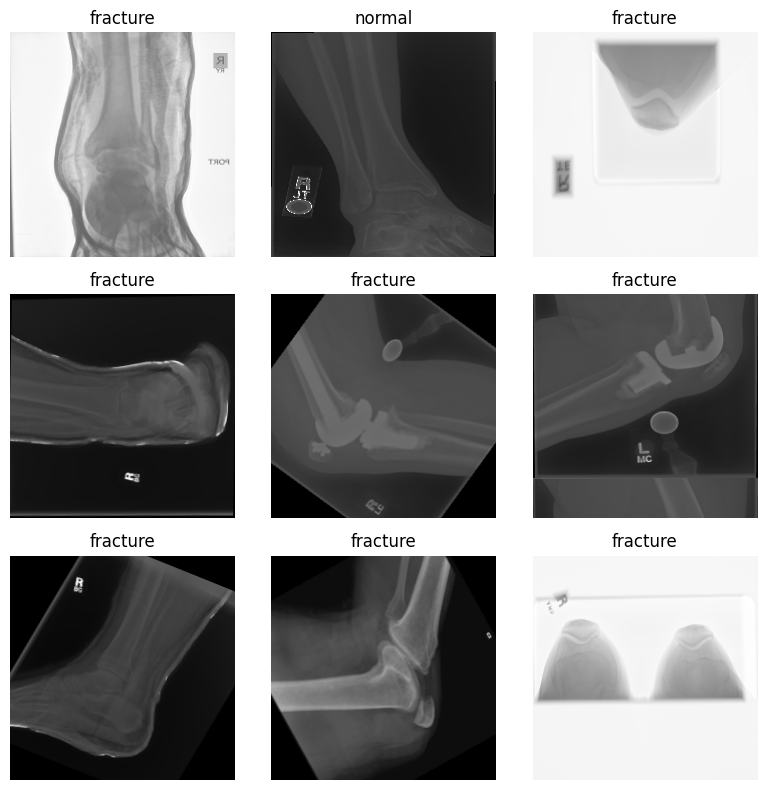

In [7]:
from google.colab import drive
drive.mount('/content/drive')
data_path="/content/drive/My Drive/Bone fracture dataset/Dataset"
train_gen, val_gen, class_names = load_custom_dataset(data_path)

print("Classes found:", class_names)
print("Displaying sample images from training set:")
display_samples(train_gen, class_names)

In [8]:

def load_dataset_numpy(root_dir, img_size=(224, 224)):
    class_names = sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ])

    print("Detected classes:", class_names)

    X, y = [], []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, fname)
                try:
                    img = Image.open(img_path).convert('RGB').resize(img_size)
                    X.append(np.array(img))
                    y.append(label)
                except Exception as e:
                    print(f"Skipped {img_path}: {e}")

    X = np.array(X)
    y = np.array(y)
    X = preprocess_input(X)
    return (X, y), class_names


In [9]:
(X, y), class_names = load_dataset_numpy(data_path)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Detected classes: ['fracture', 'normal']


In [10]:
def build_densenet_model(input_shape, n_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_densenet_model((224, 224, 3), len(class_names))
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [11]:

print("Training phase 1 (frozen base)...")
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

Training phase 1 (frozen base)...
Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8877 - loss: 0.6060 - val_accuracy: 0.9460 - val_loss: 0.1514
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9531 - loss: 0.1208 - val_accuracy: 0.9695 - val_loss: 0.0828
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9458 - loss: 0.1711 - val_accuracy: 0.9437 - val_loss: 0.1318
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9346 - loss: 0.1557 - val_accuracy: 0.9671 - val_loss: 0.0742
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9596 - loss: 0.1222 - val_accuracy: 0.9789 - val_loss: 0.0615


In [12]:
print("Evaluating baseline model ")
loss_baseline, acc_baseline = model.evaluate(X_val, y_val)
print(f"Baseline validation accuracy: {acc_baseline:.2%}")


Evaluating baseline model 
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9708 - loss: 0.0665
Baseline validation accuracy: 97.89%


####Fine-tune

In [13]:

print("Fine-tuning phase (unfreezing some layers)...")
for layer in model.layers[-10:]:  # unfreeze last 10 layers
    layer.trainable = True

model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

# Step 6: Evaluate
loss, acc = model.evaluate(X_val, y_val)
print(f"\n Final Test accuracy: {acc:.2%}")

Fine-tuning phase (unfreezing some layers)...
Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9070 - loss: 0.3860 - val_accuracy: 0.9413 - val_loss: 39.3534
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 279ms/step - accuracy: 0.9427 - loss: 0.1551 - val_accuracy: 0.9437 - val_loss: 1.8570
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.9381 - loss: 0.1462 - val_accuracy: 0.9413 - val_loss: 0.2379
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - accuracy: 0.9709 - loss: 0.0862 - val_accuracy: 0.9601 - val_loss: 0.1009
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 278ms/step - accuracy: 0.9621 - loss: 0.0839 - val_accuracy: 0.9624 - val_loss: 0.1001
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9576 - loss: 0.1027

 Final Test accuracy: 96.24%


In [15]:
print(f"Total number of layers: {len(model.layers)}")


Total number of layers: 121


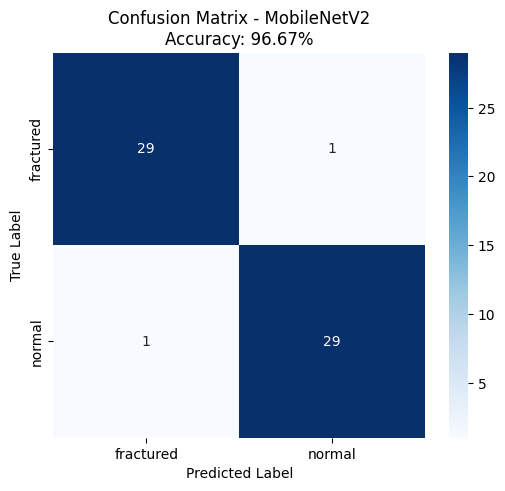

In [21]:
from google.colab import drive
drive.mount('/content/drive')

test_dir = '/content/drive/MyDrive/test'

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class_names = ['fractured', 'normal']

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=class_names
)

test_images = []
test_labels = []

for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    test_images.extend(x_batch)
    test_labels.extend(y_batch)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
